https://github.com/0liu/ISLR/blob/master/Chapter%206%20Linear%20Model%20Selection%20and%20Regularization.ipynb

### data

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Standard
from itertools import combinations

import numpy as np
import scipy as sp
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, LeaveOneOut,KFold, cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error

# from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.style.use("ggplot")

In [0]:
hitters = pd.read_csv("/content/drive/My Drive/ISLR/data/Hitters.csv", usecols = list(range(1,21)))
# 딱히 행 이름 안 쓰는 거 같아서 뺍니다.

In [0]:
# hitters.info()
hitters.describe()
# hitters.groupby() 어쩌구 하면 더 이쁘게 보이는데 기억이 안 나니 버림.

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,263.000000
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,288.937888,106.913043,8.040373,535.925882
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,280.704614,136.854876,6.368359,451.118681
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,109.250000,7.000000,3.000000,190.000000
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,212.000000,39.500000,6.000000,425.000000
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,325.000000,166.000000,11.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.00000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000,2460.000000


In [0]:
hitters.dropna(axis = 0, inplace = True)
print(hitters.shape, hitters.Salary.isnull().sum(), sep = "\n")

(263, 20)
0


In [0]:
response = "Salary"
features = hitters.columns.drop([response])

### **Subset Selection Methods**

#### 1. Best Subset Selection

아마 rss 옵션이 별로 없기도 하고, neg_mean_rss다 보니 rss 자체를 보는 함수는 없어서 만든 듯?

In [0]:
def score_rss(data, feature_set, endog_name):
  reg = smf.ols(endog_name + " ~ " + '+'.join(feature_set), data).fit()
  rss = reg.mse_resid * reg.df_resid
  return reg, (-1) * rss

나도 k-folds에 대해서 함수화하고 싶었는데, 이 분도 어지간히 반복하는 거 귀찮았구나.

sklearn.feature_selection.SelectKBest보다 단순화된 형태

In [0]:
def select_k_best(data, k, endog_name, score_function):
  features = data.columns.drop(endog_name)
  models = []; scores = []
  for feature_subset in combinations(features, k):
    model, score = score_function(data, feature_subset, endog_name)
    models.append(model); scores.append(score)
    return models[scores.index(max(scores))]

In [0]:
print("Search the best k features for k = 1 to 8, based on RSS.\nTaking long time...\n")
best_models = []
for k in range(1, 9):
  best_model = select_k_best(hitters, k, response, score_rss)
  best_models.append(best_model)
  best_features = best_model.model.exog_names
  best_features.remove("Intercept")
  print(f"Best {k} features: {best_features}")

Search the best k features for k = 1 to 8, based on RSS.
Taking long time...

Best 1 features: ['AtBat']
Best 2 features: ['AtBat', 'Hits']
Best 3 features: ['AtBat', 'Hits', 'HmRun']
Best 4 features: ['AtBat', 'Hits', 'HmRun', 'Runs']
Best 5 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI']
Best 6 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks']
Best 7 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years']
Best 8 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat']


#### 2. Forward Stepwise Selection

함수화가 편하긴 한데 함수 내용 참 이해하기 어렵다.

In [0]:
def forward_select(data, endog_name, score_function):
  features = data.columns.drop(endog_name)
  p = len(features)

  selected_features = []
  for i in range(1, p+1):
    feature_candidates = [xi for xi in features if xi not in selected_features]
    # feature_candidates = []
    # for xi in features:
    #   if(xi not in selected_features) feature_candidates.append(xi)
    models = []; scores = []
    for xi in feature_candidates:
      feature_subset = selected_features + [xi]
      model, score = score_function(data, feature_subset, endog_name)
      models.append(model); scores.append(score)
    
    best_feature = feature_candidates[scores.index(max(scores))]
    selected_features += [best_feature]
    print(f" Best {i} features: {selected_features}")

In [0]:
print("Forward stepwise select features besed on RSS:\n")
forward_select(hitters, response, score_rss)

Forward stepwise select features besed on RSS:

 Best 1 features: ['CRBI']
 Best 2 features: ['CRBI', 'Hits']
 Best 3 features: ['CRBI', 'Hits', 'PutOuts']
 Best 4 features: ['CRBI', 'Hits', 'PutOuts', 'Division']
 Best 5 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat']
 Best 6 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks']
 Best 7 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks']
 Best 8 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns']
 Best 9 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat']
 Best 10 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists']
 Best 11 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League']
 Best 12 features: ['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assist

#### 3. Backward Stepwise Selection
- BE: Backward Elimination

In [0]:
def backward_select(data, endog_name, score_function):
  features = list(data.columns.drop(endog_name))
  p = len(features)
  selected_features = features.copy()
  for i in range(p, 0, -1):
    print(f"Best {i} features: {selected_features}")
    if i == 1: break

    feature_candidates = list(combinations(selected_features, i-1))
    models = []; scores = []
    for feature_subset in feature_candidates:
      model, score = score_function(data, feature_subset, endog_name)
      models.append(model); scores.append(score)
    
    selected_features = list(feature_candidates[scores.index(max(scores))])

전체 length를 p로 받아서 전체부터 combinations에 반복적으로 제거해서 score 점수를 list로 저장하는데, 이 중, 제일 큰 값의 변수들을 모아 보여주는 거지.

In [0]:
print("Backward stepwise select features based on RSS:\n")
backward_select(hitters, response, score_rss)

Backward stepwise select features based on RSS:

Best 19 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague']
Best 18 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague']
Best 17 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague']
Best 16 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors']
Best 15 features: ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors']
Best 14 features: ['AtBat', 'Hits', 'HmRun', '

#### 4. choose model using Validation and Cross-Validation
- FS로 실습한 것.

> ##### Validation set Approach

In [0]:
def score_rss_valset(data_train, data_test, feature_set, endog_name):
  reg = smf.ols(endog_name + " ~ " + '+'.join(feature_set), data_train).fit()
  y_pred = reg.predict(data_test[feature_set])
  y_test = data_test[endog_name].values
  rss = ((y_pred - y_test)**2).sum()
  return reg, (-1) * rss

In [0]:
def forward_select_valset(data_train, data_test, endog_name, score_function):
  features = data_train.columns.drop(endog_name)
  p = len(features)

  high_scores = []; best_features = []; selected_features = []
  for i in range(1, p+1):
    feature_candidates = [xi for xi in features if xi not in selected_features]
    # feature_candidates = []
    # for xi in features
    #   if(xi not in selected_features) feature_candidates.append(xi)
    models = []; scores = []
    for xi in feature_candidates:
      feature_subset = selected_features + [xi]
      model, score = score_function(data_train, data_test, feature_subset, endog_name)
      models.append(model); scores.append(score)
    
    highest_score = max(scores)
    high_scores.append(highest_score)
    best_feature = feature_candidates[scores.index(highest_score)]
    selected_features += [best_feature]
    best_features.append(selected_features)
  
  scores_df = pd.DataFrame(high_scores, index = range(1, p+1), columns = [''])
  scores_df.index.name = "# of x_i"

  best_score = max(high_scores)
  best_i = high_scores.index(best_score) + 1
  return scores_df, best_i, best_score, best_features

으.. seed 고정하는 거 지우고 하고 싶다.

In [0]:
np.random.seed(seed = 51)
train_mask = np.random.choice([True, False], size = hitters.shape[0], replace = True)
test_mask = np.invert(train_mask)
print("Train set size = ", train_mask.sum())
print("Test set size = ", test_mask.sum())

Train set size =  142
Test set size =  121


19개의 변수에 대해 다 rss를 찍어보자.

In [0]:
print("Forward steopwise select features on training set, based on RSS.\n")
scores_valset, best_i_valset, best_score, best_features_valset = forward_select_valset(hitters[train_mask],
    hitters[test_mask], response, score_rss_valset)

mean_rss_valset = scores_valset * (-1)
print("Mean RSS over numbers of features", mean_rss_valset)

print(f"\nThe best model is the one having {best_i_valset} features\n{best_features_valset[best_i_valset - 1]}")

Forward steopwise select features on training set, based on RSS.

Mean RSS over numbers of features                       
# of x_i              
1         2.076650e+07
2         1.714363e+07
3         1.617621e+07
4         1.588872e+07
5         1.562742e+07
6         1.508433e+07
7         1.478177e+07
8         1.467281e+07
9         1.452479e+07
10        1.449917e+07
11        1.465030e+07
12        1.493468e+07
13        1.508188e+07
14        1.557057e+07
15        1.620118e+07
16        1.624116e+07
17        1.698257e+07
18        1.730889e+07
19        1.763893e+07

The best model is the one having 10 features
['CRBI', 'Hits', 'Division', 'Years', 'AtBat', 'Walks', 'PutOuts', 'CWalks', 'CRuns', 'RBI', 'Errors', 'Assists', 'HmRun', 'Runs', 'NewLeague', 'League', 'CHmRun', 'CAtBat', 'CHits']


위에는 training data에 대한 (전진) 변수 선택이었다면, 밑에는 full data에 대한 (여전히 전진) 변수 선택 순서.

In [0]:
_, _, _, best_features_full = forward_select_valset(hitters, hitters, response, score_rss_valset)
print("Forward stepwise select features on full data set, based on RSS.\n",
      f"The best {best_i_valset} features are\n{best_features_full[best_i_valset-1]}")

Forward stepwise select features on full data set, based on RSS.
 The best 10 features are
['CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League', 'Runs', 'Errors', 'HmRun', 'CHits', 'RBI', 'NewLeague', 'Years', 'CHmRun']


> ##### Cross-Validation

In [0]:
kf = KFold(10, random_state = 55)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [0]:
scores_cv_list = []
for train_index, test_index in kf.split(hitters):
  scores_df, _, _, _ = forward_select_valset(hitters.iloc[train_index], hitters.iloc[test_mask],
                                             response, score_rss_valset)
  scores_cv_list.append(scores_df)

scores_cv = pd.concat(scores_cv_list, axis = 1)
scores_cv.columns = range(1, 11)
scores_cv.columns.name = "K-Fold"

In [0]:
mean_rss_cv = scores_cv.mean(axis = 1) * (-1)
mean_rss_cv

# of x_i
1     1.988162e+07
2     1.469190e+07
3     1.247908e+07
4     1.182492e+07
5     1.148818e+07
6     1.094343e+07
7     1.082744e+07
8     1.081981e+07
9     1.079096e+07
10    1.076345e+07
11    1.058229e+07
12    1.048883e+07
13    1.043509e+07
14    1.035223e+07
15    1.029475e+07
16    1.021250e+07
17    1.019581e+07
18    1.021123e+07
19    1.029496e+07
dtype: float64

> ##### Validation vs Cross-Validation
- plot 비교, FS 선택법

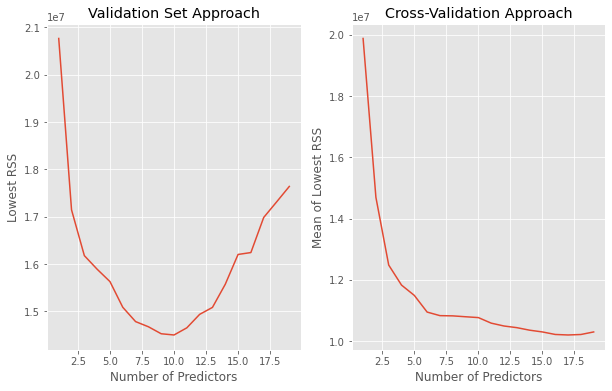

In [0]:
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

ax1 = plt.subplot(121)
plt.plot(range(1, len(features) + 1), mean_rss_valset)
plt.title("Validation Set Approach")
plt.xlabel("Number of Predictors")
plt.ylabel("Lowest RSS")

ax2 = plt.subplot(122)
plt.plot(range(1, len(features) + 1), mean_rss_cv)
plt.title("Cross-Validation Approach")
plt.xlabel("Number of Predictors")
plt.ylabel("Mean of Lowest RSS")

plt.show()

### 데이터 작업

full data로 alpha가 10^10에서 10^(-2)로 변할 때의 편회귀계수의 변화 plot
- alpha:  아마도 ridge 방정식?에 등장하는 lambda나 그에 비례하는 값으로 보임.
- lambda처럼 그 값이 클 때는 (편)회귀계수의 값이 0에 수렴함.
- 정규화 가정치로 불림.

In [0]:
alphas = 10**np.linspace(10, -2, 100)

Validation set Approach를 위한 작업

In [0]:
qual_vars = ["League", "Division", "NewLeague"]
hitters_dummies = pd.get_dummies(hitters[qual_vars])
hitters_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6 KB


League, Division, NewLeague는 당연히 hitters의 행(14, 15, 20)이며, 더미변수화된 갯수로 볼 때, 세 질적 변수는 모두 2개의 옵션을 가지고 있었던 것으로 보인다.

qual_vars로 선언한 세 변수에 대해서 한쪽 값만 가진 데이터를 사용함.

In [0]:
dummy_vars = ["League_N", "Division_W", "NewLeague_N"]
X = pd.concat([hitters.drop(qual_vars + [response], axis = 1), hitters_dummies[dummy_vars]], axis = 1)
y = hitters[response]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   AtBat        263 non-null    int64
 1   Hits         263 non-null    int64
 2   HmRun        263 non-null    int64
 3   Runs         263 non-null    int64
 4   RBI          263 non-null    int64
 5   Walks        263 non-null    int64
 6   Years        263 non-null    int64
 7   CAtBat       263 non-null    int64
 8   CHits        263 non-null    int64
 9   CHmRun       263 non-null    int64
 10  CRuns        263 non-null    int64
 11  CRBI         263 non-null    int64
 12  CWalks       263 non-null    int64
 13  PutOuts      263 non-null    int64
 14  Assists      263 non-null    int64
 15  Errors       263 non-null    int64
 16  League_N     263 non-null    uint8
 17  Division_W   263 non-null    uint8
 18  NewLeague_N  263 non-null    uint8
dtypes: int64(16), uint8(3)
memory usage: 35.7 KB


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1)

### **Ridge Regression**
- 결론: Ridge는 제곱 값을 방정식에 끼고 있어서 어떤 계수도 정확히 0이 되지 않는다. 따라서, 들어간 모든 변수를 하나도 소거하지 않는다.

In [0]:
ridge = Ridge();  coefs = []
for alpha in alphas:
  ridge.set_params(alpha = alpha * 0.5) # alpha / 2
  ridge.fit(scale(X), y)
  coefs.append(ridge.coef_)

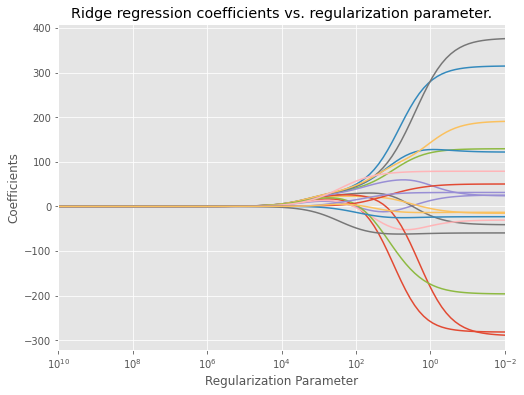

In [0]:
fit, ax = plt.subplots(figsize = (8, 6))
plt.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlim(1e10, 1e-2)
plt.xlabel("Regularization Parameter")
plt.ylabel("Coefficients")
plt.title("Ridge regression coefficients vs. regularization parameter.")
plt.show()

plot을 통해 전체적인 모양을 봤으니 몇 가지 값을 뽑아서 해당 계수값의 변화를 보자.

> #### 1. alpha = 4 (Validation set Approach)

In [0]:
ridge_a4 = Ridge(alpha = 4, normalize = True)
ridge_a4.fit(X_train, y_train)
y_pred_a4 = ridge_a4.predict(X_test)
print("Ridge regression coefficients", pd.Series(ridge_a4.coef_, index = features), sep = "\n")
print("\nMSE = ", mean_squared_error(y_test, y_pred_a4))

Ridge regression coefficients
AtBat         0.098658
Hits          0.446094
HmRun         1.412107
Runs          0.660773
RBI           0.843403
Walks         1.008473
Years         2.779882
CAtBat        0.008244
CHits         0.034149
CHmRun        0.268634
CRuns         0.070407
CRBI          0.070060
CWalks        0.082795
League        0.104747
Division     -0.003739
PutOuts       0.268363
Assists       4.241051
Errors      -30.768885
NewLeague     4.123474
dtype: float64

MSE =  106216.52238005561


> #### 2. alpha = 10^10 (Validation set Approach)

In [0]:
ridge_a1e10 = Ridge(alpha = 10**10, normalize = True)
ridge_a1e10.fit(X_train, y_train)
y_pred_a1e10 = ridge_a1e10.predict(X_test)
print("Ridge regression coefficients", pd.Series(ridge_a1e10.coef_, index = features), sep = "\n")
print("\nMSE = ", mean_squared_error(y_test, y_pred_a1e10))

Ridge regression coefficients
AtBat        1.317464e-10
Hits         4.647486e-10
HmRun        2.079865e-09
Runs         7.726175e-10
RBI          9.390640e-10
Walks        9.769219e-10
Years        3.961442e-09
CAtBat       1.060533e-11
CHits        3.993605e-11
CHmRun       2.959428e-10
CRuns        8.245247e-11
CRBI         7.795451e-11
CWalks       9.894387e-11
League       7.268991e-11
Division    -2.615885e-12
PutOuts      2.084514e-10
Assists     -2.501281e-09
Errors      -1.549951e-08
NewLeague   -2.023196e-09
dtype: float64

MSE =  172862.23580379886


> #### 3. CV-optimized alpha (full data)

In [0]:
ridgecv = RidgeCV(alphas = alphas * 0.5, scoring = "neg_mean_squared_error", normalize = True)
ridgecv.fit(X_train, y_train)
print("The best ridge regularization Alpha =", ridgecv.alpha_)

The best ridge regularization Alpha = 0.553366992312063


In [0]:
ridge_cv = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge_cv.fit(X_train, y_train)
print("MSE =", mean_squared_error(y_test, ridge_cv.predict(X_test)))

MSE = 99868.65157728657


In [0]:
ridge_cv.fit(X, y)
print(pd.Series(ridge_cv.coef_, index = features))

AtBat         0.051670
Hits          0.948315
HmRun         0.327691
Runs          1.096752
RBI           0.877613
Walks         1.733660
Years         0.673612
CAtBat        0.011298
CHits         0.061758
CHmRun        0.432269
CRuns         0.122694
CRBI          0.130809
CWalks        0.039826
League        0.182182
Division      0.036924
PutOuts      -1.638026
Assists      25.226182
Errors      -87.054059
NewLeague     8.156035
dtype: float64


### **The Lasso**
- 아무래도 max_iter의 값은 lasso 방정식 특정상 엄청나게 큰 값이 나올 수도 있어 해당 값보다 큰 값은 구하지 않겠다는 상한선의 값으로 보인다.
- 결론: 역시 제곱식이 방정식에 들어가지 않으니 실제로 0이 나오네.

In [0]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
for alpha in alphas:
  lasso.set_params(alpha = alpha)
  lasso.fit(scale(X_train), y_train)
  coefs.append(lasso.coef_)

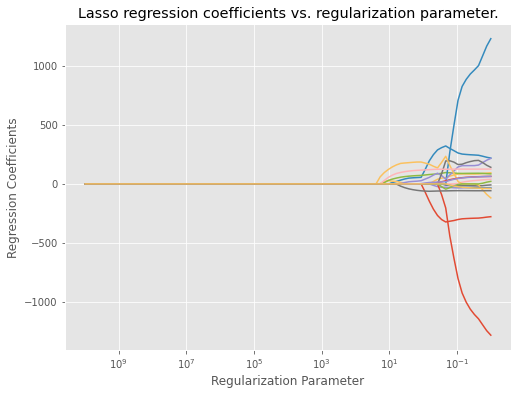

In [0]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.plot(alphas, coefs)

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])
# Ridge에서는 정해진 값 안에서 해서 뒤집어 보여주기 쉬웠으나, lasso는 값을 확인하지 않아서
# 정의된 모든 값을 보여주되, 뒤집어 보여달란 뜻이었음.

plt.xlabel("Regularization Parameter")
plt.ylabel("Regression Coefficients")
plt.title("Lasso regression coefficients vs. regularization parameter.")
plt.show()

> #### CV-optimized alpha (full data)

In [0]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)
print("The best Lasso regularization Alpha =", lassocv.alpha_)

The best Lasso regularization Alpha = 2.402973015740077


In [0]:
lasso_cv = Lasso(max_iter = 10000, normalize = True, alpha = lassocv.alpha_)
lasso_cv.fit(X_train, y_train)
print("MSE =", mean_squared_error(y_test, lasso_cv.predict(X_test)))

MSE = 104960.65853895503


In [0]:
pd.Series(lasso_cv.coef_, index = features)

AtBat         0.000000
Hits          1.082446
HmRun         0.000000
Runs          0.000000
RBI           0.000000
Walks         2.906388
Years         0.000000
CAtBat        0.000000
CHits         0.000000
CHmRun        0.219367
CRuns         0.000000
CRBI          0.513975
CWalks        0.000000
League        0.368401
Division     -0.000000
PutOuts      -0.000000
Assists       0.000000
Errors      -89.064338
NewLeague     0.000000
dtype: float64

### **PCR and PLS Regression**

In [0]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 1)

> #### PCR: Principal Components (analysis) Regression

In [0]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))
print("The shape of loading matrix:", pca.components_.shape)
print("Head of loading matrix\n", pd.DataFrame(pca.components_.T).loc[:4, :5])

The shape of loading matrix: (19, 19)
Head of loading matrix
           0         1         2         3         4         5
0  0.198290 -0.383784  0.088626  0.031967  0.028117 -0.070646
1  0.195861 -0.377271  0.074032  0.017982 -0.004652 -0.082240
2  0.204369 -0.237136 -0.216186 -0.235831  0.077660 -0.149646
3  0.198337 -0.377721 -0.017166 -0.049942 -0.038536 -0.136660
4  0.235174 -0.314531 -0.073085 -0.138985  0.024299 -0.111675


##### on full data

In [0]:
regr = LinearRegression();  mse = []
for n_pc in range(0, pca.n_components_ + 1):
  if n_pc == 0: X_regr = np.ones((len(y), 1))
  else: X_regr = X_reduced[:, :n_pc]
  scores = cross_val_score(regr, X_regr, y, cv = kf, scoring = "neg_mean_squared_error", )
  # 맞다, cv는 train, validation을 나누는 방법론에 대해 적는 거였지.
  mse.append(scores.mean() * (-1))

pca.fit에서 나온 값은 variance가 가장 큰 값부터의 선형 변환된 값이자 축들이 있을 거고, 이거랑 y를 추정한 선형 모델의 score(mse)를 K-Fold를 통해 10번을 반복했을 때의 최소 mse를 mse에 저장하는 것.

- 잘하면 어떤 축들끼리 y를 설명할 때 상극?인지 보이기도 할 듯.
- 아니면 정말 변환했을 때 상극을 넣은 걸 수도 있고.

In [0]:
min_mse = min(mse)
min_mse_idx = mse.index(min_mse)

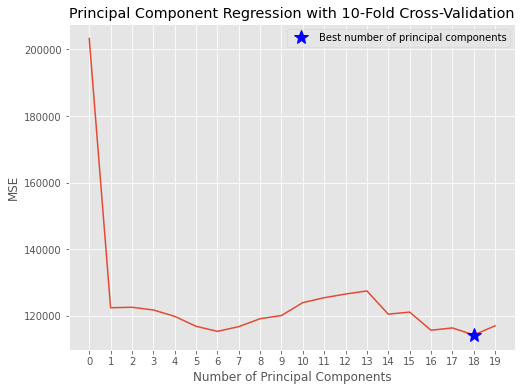

In [0]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.plot(mse)

plt.xticks(range(20)) # 하나는 label 값이거나 다른 값이었나? 필요없었던 것 같다.
plt.xlabel("Number of Principal Components")
plt.ylabel("MSE")
plt.title("Principal Component Regression with 10-Fold Cross-Validation")

min_mse_marker, = plt.plot(min_mse_idx, min_mse, "b*", markersize = 15)
plt.legend([min_mse_marker], ["Best number of principal components"])
plt.show()

y축의 한 칸이 큰 값이긴 해도 mse를 최소화하기 위해 변수를 18개나 모델에 넣는 건 아무래도 비효율적.

게다가 pca를 했는데 변수를 하나만 줄였다?는 모델 해석력을 포기하겠다는 뜻으로밖에 해석되지 않음.

In [0]:
evr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)

In [0]:
print("Explained Variance Ratio")
i = 0
for p in evr:
  print("%2d %.2f %%" %(i, p), end = "\n")
  i = i + 1
# 간만에 %-formating. f-formating은 다 좋은데, 자릿수 지정하려면 round를 써야해서 귀찮아.

Explained Variance Ratio
 0 38.31 %
 1 60.15 %
 2 70.84 %
 3 79.03 %
 4 84.29 %
 5 88.63 %
 6 92.26 %
 7 94.96 %
 8 96.28 %
 9 97.25 %
10 97.97 %
11 98.64 %
12 99.14 %
13 99.46 %
14 99.73 %
15 99.88 %
16 99.95 %
17 99.98 %
18 99.99 %


##### 0번을 없애보면 어떨까.

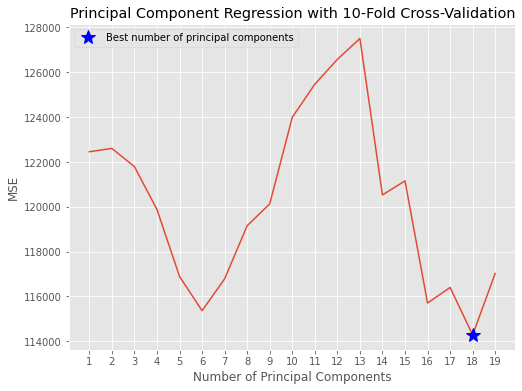

In [0]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.plot(mse[1:])

plt.xticks(range(20), labels = range(1, 20))
plt.xlabel("Number of Principal Components")
plt.ylabel("MSE")
plt.title("Principal Component Regression with 10-Fold Cross-Validation")

min_mse_marker, = plt.plot(min_mse_idx - 1, min_mse, "b*", markersize = 15)
plt.legend([min_mse_marker], ["Best number of principal components"])
plt.show()

일부러 보기 쉬우라고 0번을 제거하긴 했지만, 아직도 mse 한 칸의 값이 커서 의미가 없는 것 같다. 그냥 모델 적합도를 버리고 2차원이나 3차원을 선택해서 해석을 하는 게 더 나아보인다.

##### on training data

In [0]:
X_train_reduced = pca.fit_transform(scale(X_train))

In [0]:
regr = LinearRegression();  mse = []
for n_pc in range(0, pca.n_components_ + 1):
  if n_pc == 0: X_regr = np.ones((len(y_train), 1))
  else: X_regr = X_train_reduced[:, :n_pc]
  scores = cross_val_score(regr, X_regr, y_train, cv = kf, scoring = "neg_mean_squared_error")
  mse.append(scores.mean() * (-1))

In [0]:
min_mse = min(mse)
min_mse_idx = mse.index(min_mse)

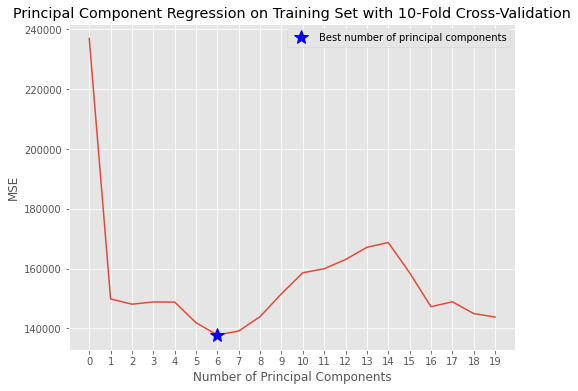

In [0]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.plot(mse)

plt.xticks(range(20))
plt.xlabel("Number of Principal Components")
plt.ylabel("MSE")
plt.title("Principal Component Regression on Training Set with 10-Fold Cross-Validation")

min_mse_marker, = plt.plot(min_mse_idx, min_mse, "b*", markersize = 15)
plt.legend([min_mse_marker], ["Best number of principal components"])
plt.show()

In [0]:
regr = LinearRegression()
regr.fit(X_train_reduced[:, :7], y_train)
X_test_reduced = pca.transform(scale(X_test))[:, :7]
print("Test set MSE =", mean_squared_error(y_test, regr.predict(X_test_reduced)))

Test set MSE = 111994.42273636989


pca를 했는데 변수를 6개 선택한다? 생각보다 많이 이상한 짓인 것 같음.

> #### PLS: Partial Least Squares

In [0]:
mse = []
for i in range(1, 20):
  pls = PLSRegression(n_components = i)
  scores = cross_val_score(pls, scale(X_train), y_train, cv = kf, scoring = "neg_mean_squared_error")
  mse.append(scores.mean() * (-1))

In [0]:
min_mse = min(mse)
min_mse_idx = mse.index(min_mse) + 1

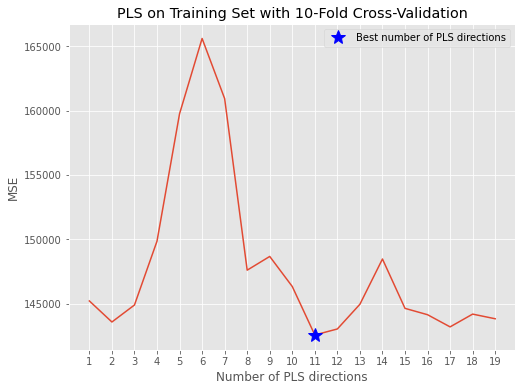

In [0]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.plot(range(1, 20), mse)

plt.xticks(range(20))
plt.xlabel("Number of PLS directions")
plt.ylabel("MSE")
plt.title("PLS on Training Set with 10-Fold Cross-Validation")

min_mse_marker, = plt.plot(min_mse_idx, min_mse, "b*", markersize = 15)
plt.legend([min_mse_marker], ["Best number of PLS directions"])
plt.show()

아~ 함수가 바뀌었나 보다~

In [0]:
pls = PLSRegression(n_components = 2)
pls.fit(scale(X_train), y_train)
mean_squared_error(y_test, pls.predict(scale(X_test)))

104838.51042760801